In [1]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
# Install and import necessary libraries
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('cleaned_spy_1min.csv', index_col=0, parse_dates=True)
series = df.tail(100000)
series.sort_index(inplace=True)

In [4]:
print(len(series))

100000


In [5]:
print(series.isna().sum())


date        0
open        0
high        0
low         0
close       0
volume      0
barCount    0
average     0
return      0
hour        0
dtype: int64


In [6]:
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 80000, Test size: 20000


In [7]:
train_close = train['close'].astype(float)

# Define SARIMA orders
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 5)

# Build & fit model on the 'close' series
model = SARIMAX(
    train_close,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary().tables[1])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1337     37.826     -0.004      0.997     -74.271      74.004
ma.L1          0.1338     37.825      0.004      0.997     -74.002      74.270
ar.S.L5       -0.0002      0.060     -0.003      0.998      -0.118       0.118
ma.S.L5       -1.0000      0.010   -102.875      0.000      -1.019      -0.981
sigma2        23.9458      0.233    102.866      0.000      23.490      24.402


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Test RMSE: 99.3548


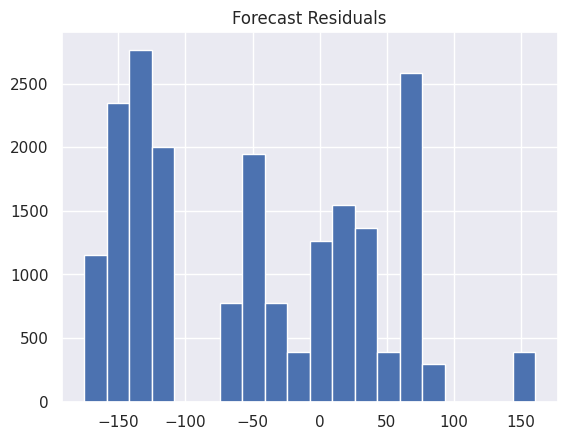

In [8]:
# Number of test points
n_test = len(test)

# Forecast object
forecast_obj = results.get_forecast(steps=n_test)
pred = forecast_obj.predicted_mean

# Align forecast index with test index
pred.index = test.index  # test.index must be datetime or same as train

# Compute RMSE on close price only
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['close'], pred))
print(f"Test RMSE: {rmse:.4f}")

# (Optional) plot the residuals histogram
residuals = test['close'] - pred
residuals.hist(bins=20)
plt.title("Forecast Residuals")
plt.show()

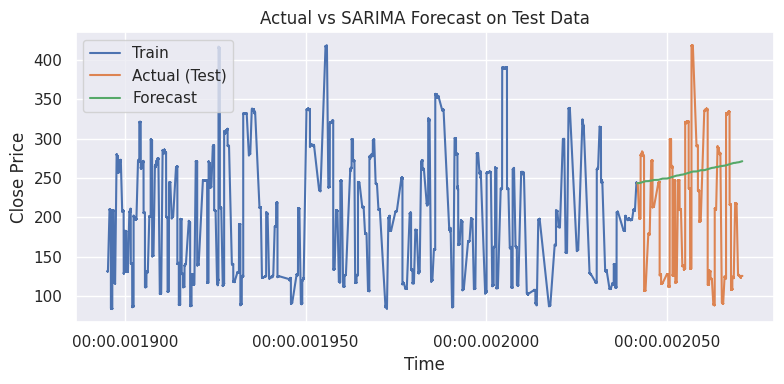

In [9]:
plt.figure(figsize=(8,4))

# Plot the 'close' column, not the whole DataFrame
plt.plot(train.index, train['close'], label='Train')
plt.plot(test.index, test['close'], label='Actual (Test)')
plt.plot(test.index, pred, label='Forecast')

plt.legend()
plt.title('Actual vs SARIMA Forecast on Test Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.tight_layout()
plt.show()

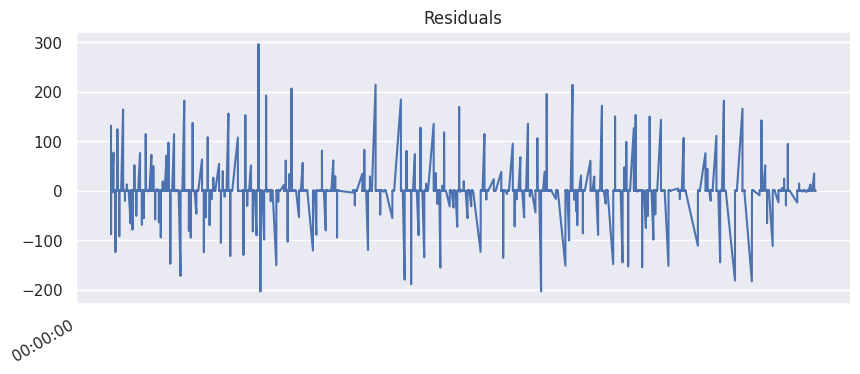

In [10]:
residuals = results.resid
residuals.plot(title="Residuals", figsize=(10, 4))
plt.show()

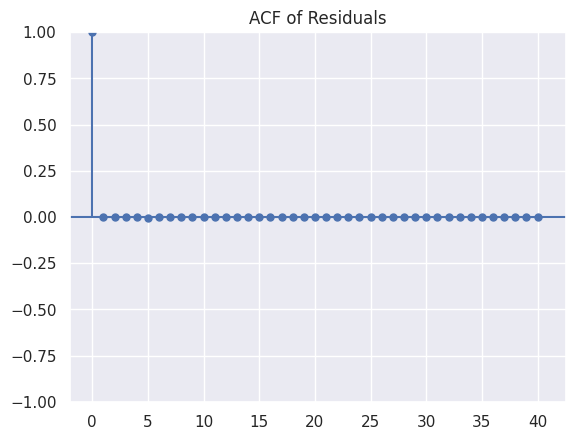

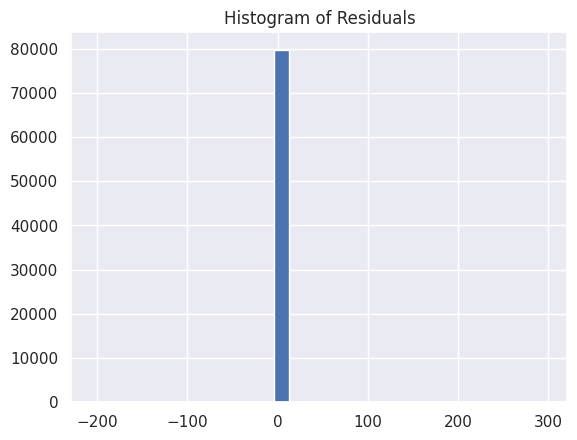

In [11]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=40)
plt.title("ACF of Residuals")
plt.show()

residuals.hist(bins=30)
plt.title("Histogram of Residuals")
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


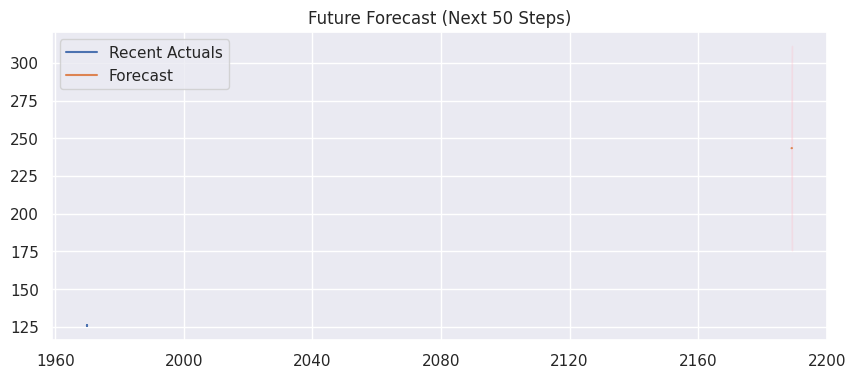

In [12]:
future_steps = 50
future_forecast = results.get_forecast(steps=future_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

# Plot future forecast
plt.figure(figsize=(10, 4))
plt.plot(series.index[-100:], series['close'].tail(100), label='Recent Actuals')
plt.plot(future_mean.index, future_mean, label='Forecast')
plt.fill_between(future_ci.index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Future Forecast (Next 50 Steps)")
plt.legend()
plt.show()

In [14]:
import joblib

# 1. Save the fitted model to a file
joblib.dump(model, 'sarima_model.pkl')
print("Model saved to sarima_model.pkl")

# 2. If in Colab, provide a download link
from google.colab import files
files.download('sarima_model.pkl')

Model saved to sarima_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>